<div style="padding:20px; color:#FFFFFF; margin:0;font-size:250%;text-align:center;display:fill;border-radius:5px;background-color:#3778ba;overflow:hidden;font-weight:700">
Forecasting taxi orders 🚕
</div>    

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-|-Introduction-" data-toc-modified-id="1-|-Introduction--0"><b><span style="color:#3778ba">1 |</span><span style="color:#3778ba"> Introduction </span></b></a></span></li><li><span><a href="#2-|-Data-loading" data-toc-modified-id="2-|-Data-loading-1"><b><span style="color:#3778ba">2 |</span><span style="color:#3778ba"> Data loading</span></b></a></span></li><li><span><a href="#3-|-EDA" data-toc-modified-id="3-|-EDA-2"><b><span style="color:#3778ba">3 | </span><span style="color:#3778ba">EDA</span></b></a></span></li><li><span><a href="#4-|-New-features" data-toc-modified-id="4-|-New-features-3"><b><span style="color:#3778ba">4 | </span><span style="color:#3778ba">New features</span></b></a></span></li><li><span><a href="#5-|-Модели" data-toc-modified-id="5-|-Модели-4"><b><span style="color:#3778ba">5 | </span><span style="color:#3778ba">Модели</span></b></a></span><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-4.1"><b><span style="color:#4caba4">Baseline</span></b></a></span></li><li><span><a href="#Hyperparameter-tunning" data-toc-modified-id="Hyperparameter-tunning-4.2"><b><span style="color:#4caba4">Hyperparameter tunning</span></b></a></span></li><li><span><a href="#Cross-validation-of-best-model" data-toc-modified-id="Cross-validation-of-best-model-4.3"><strong><span style="color:#4caba4">Cross-validation of best model</span></strong></a></span></li><li><span><a href="#Model-testing" data-toc-modified-id="Model-testing-4.4"><b><span style="color:#4caba4">Model testing</span></b></a></span></li></ul></li><li><span><a href="#6-|-Conclusions-" data-toc-modified-id="6-|-Conclusions--5"><b><span style="color:#3778ba">6 |</span><span style="color:#3778ba"> Conclusions </span></b></a></span></li></ul></div>

## <b><span style='color:#3778ba'>1 |</span><span style='color:#3778ba'> Introduction </span></b>

The Taxi company has collected historical data on taxi orders at airports. To attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour.

**<span style="color:#4caba4; font-size:120%">Data</span>** 

The data is in the taxi.csv file. The number of orders is in the num_orders column.

**<span style="color:#4caba4;font-size:120%">Aim</span>**

Create a model to predict the number of taxi orders

**<span style="color:#4caba4;font-size:120%">Metrics</span>**

RMSE 
The value of the metric on the test sample should not exceed 48.

## <b><span style='color:#3778ba'>2 |</span><span style='color:#3778ba'> Data loading</span></b>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
#-----------------------------
from sklearn.model_selection import KFold, cross_validate, train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

#----------------------------
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")



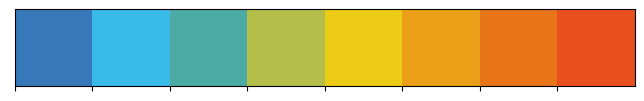

In [2]:
my_colors = ["#3778ba", "#37bae8", "#4caba4", "#b3bf49",
             "#edcc17", "#eb9f19", "#e9751a", "#e84f1c"]
sns.palplot(sns.color_palette(my_colors))

In [3]:
server_path = '/datasets/taxi.csv'
local_path= 'taxi.csv'

try:
    df = pd.read_csv(server_path, index_col='datetime', parse_dates=['datetime'])
except:
    df = pd.read_csv(local_path, index_col='datetime', parse_dates=['datetime'])

## <b><span style='color:#3778ba'>3 | </span><span style='color:#3778ba'>EDA</span></b>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.shape

(26496, 1)

In [6]:
df.isna().sum()

num_orders    0
dtype: int64

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
df.index.is_monotonic

True

<div style="padding:10px; color:white; font-size:120%; display:fill; background-color:#4caba4;">
    
+ Loaded data
    
+ No missing values
    
+ Data in the right order
</div>


In [9]:
df = df.resample('1H').sum()

In [10]:
decomposition = seasonal_decompose(df)

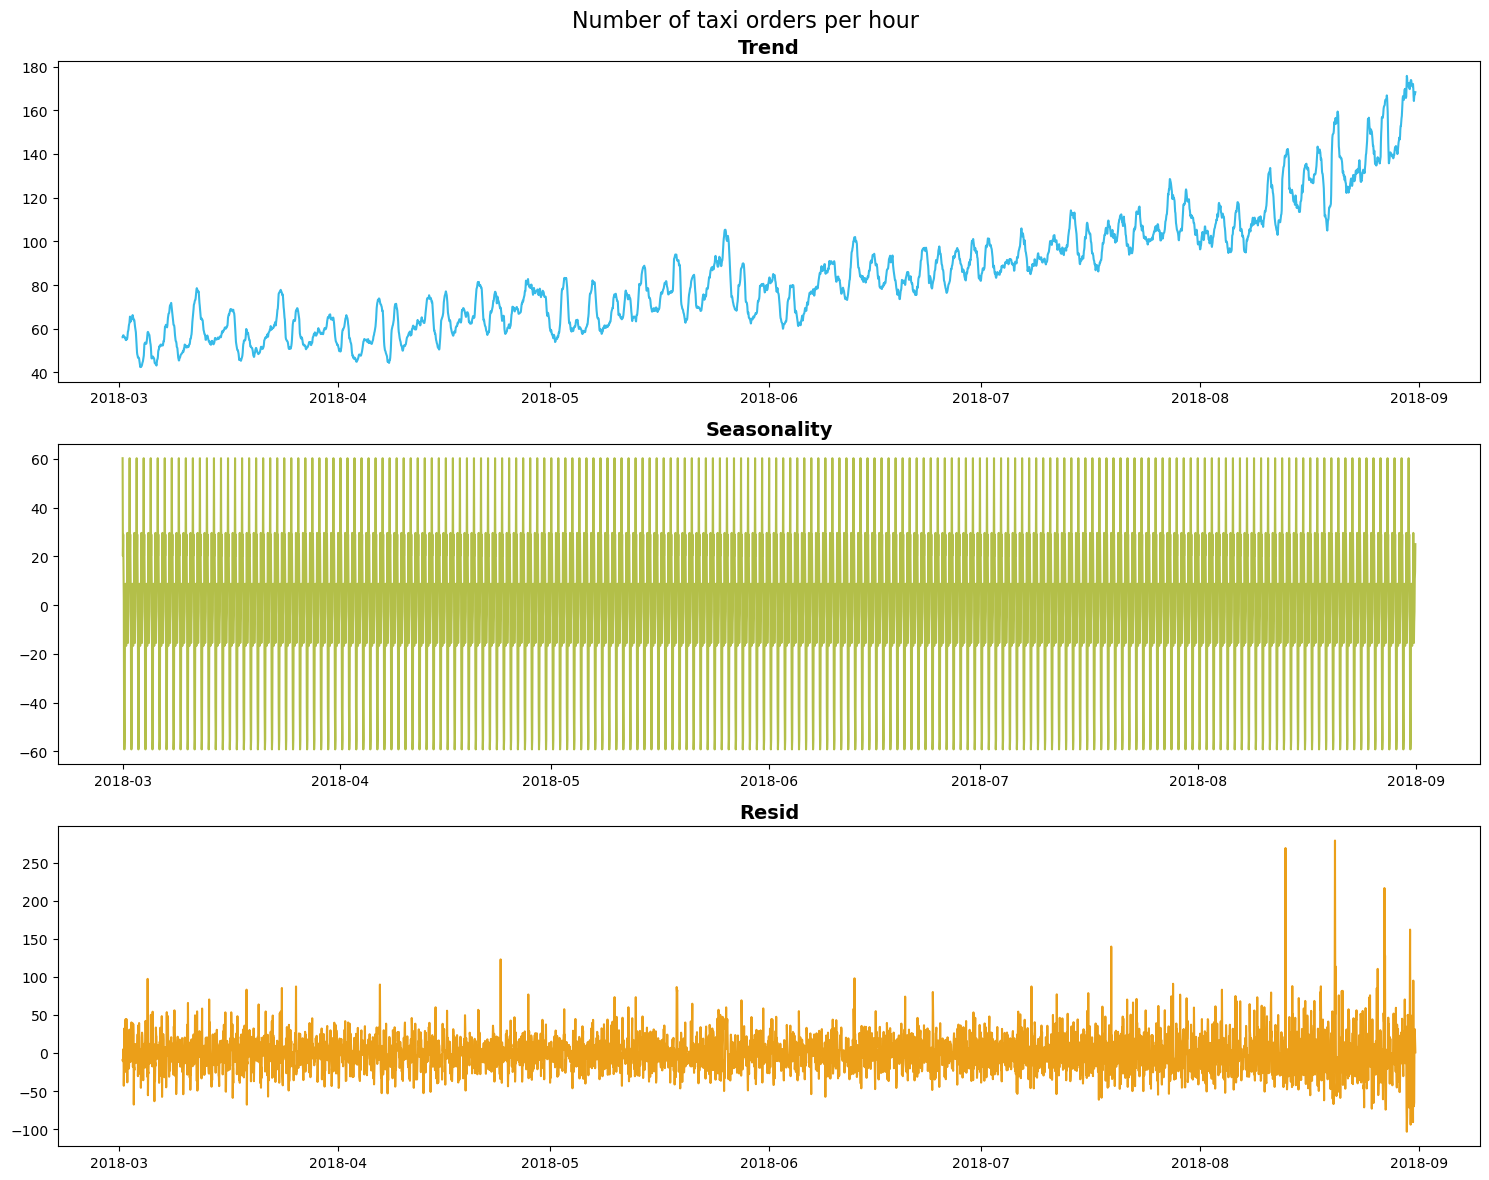

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
ax[0].plot(decomposition.trend, color=my_colors[1])
ax[0].set_title('Trend',size=14, weight='bold')
ax[1].plot(decomposition.seasonal, color=my_colors[3])
ax[1].set_title('Seasonality', size=14, weight='bold')
ax[2].plot(decomposition.resid, color=my_colors[5])
ax[2].set_title('Resid', size=14, weight='bold')
fig.suptitle('Number of taxi orders per hour', size=16)
fig.tight_layout()

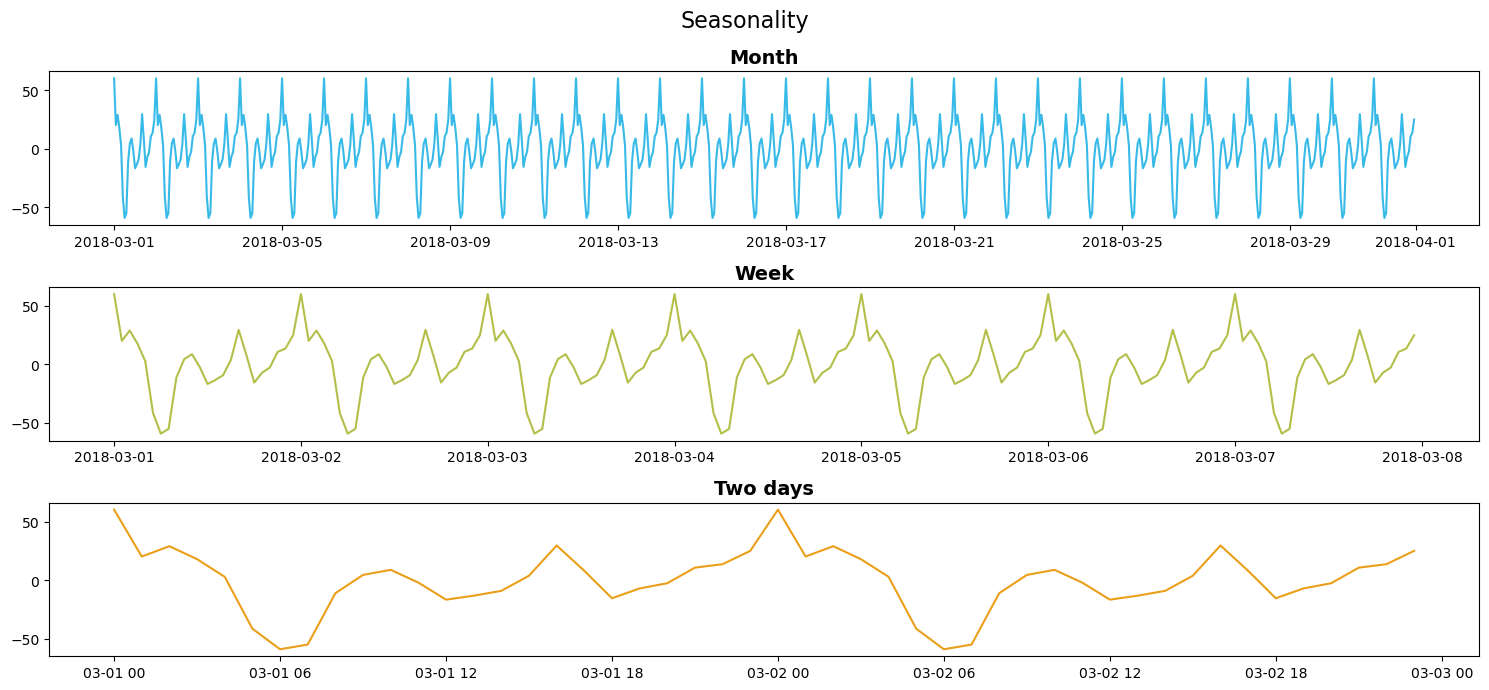

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(15, 7))
ax[0].plot(decomposition.seasonal['2018-03-01':'2018-03-31'], color=my_colors[1])
ax[0].set_title('Month', size=14, weight='bold')
ax[1].plot(decomposition.seasonal['2018-03-01':'2018-03-07'], color=my_colors[3])
ax[1].set_title('Week', size=14, weight='bold')
ax[2].plot(decomposition.seasonal['2018-03-01':'2018-03-02'], color=my_colors[5])
ax[2].set_title('Two days', size=14, weight='bold')
fig.suptitle('Seasonality', size=16)
fig.tight_layout()

<div style="padding:10px; color:white; font-size:120%; display:fill; background-color:#4caba4;">
    
+ The number of orders from March to September gradually increased.
    
    
+ During the day, the number of orders changes: in the evening from 18:00 the number of orders increases, after 0:00 demand drops with a minimum at 6:00
</div>


## <b><span style='color:#3778ba'>4 | </span><span style='color:#3778ba'>New features</span></b>

**<span style="color:#4caba4; font-size:120%">Calendar features</span>** 

In [13]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day

    return df

df = create_features(df)

**<span style="color:#4caba4; font-size:120%">Lagging values</span>** 

In [16]:
def add_lags(df, max_lag):
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    return df

df = add_lags(df, 24)

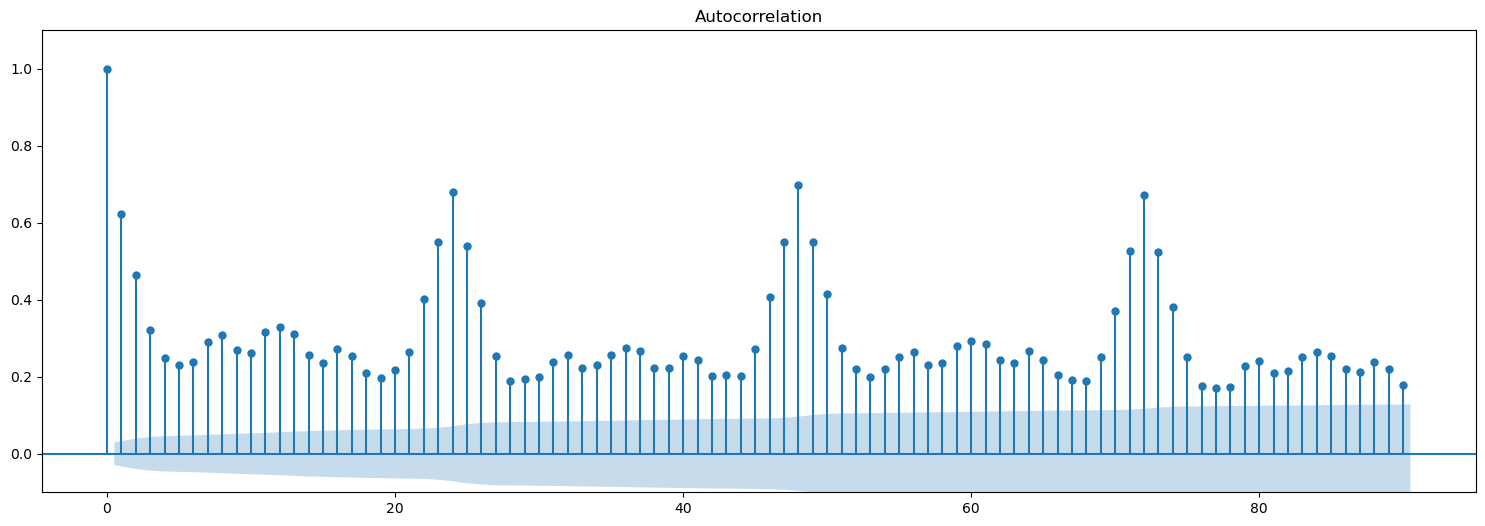

In [17]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(df['num_orders'],lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


**<span style="color:#4caba4; font-size:120%">Rolling mean</span>** 

In [18]:
df['rolling_mean'] = df['num_orders'].shift().rolling(7).mean()

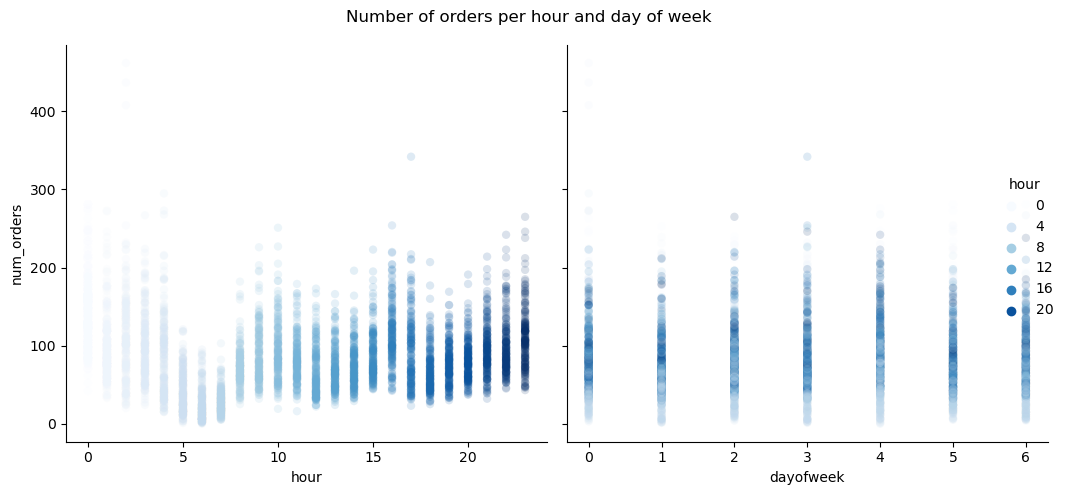

In [19]:
sns.pairplot(df,
             hue='hour',
             x_vars=['hour','dayofweek'],
             y_vars='num_orders',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0},
             palette="Blues")

plt.suptitle('Number of orders per hour and day of week')
plt.tight_layout()

**<span style="color:#4caba4; font-size:120%">Splitting </span>** 

In [21]:
train, test = train_test_split(df, test_size=0.1, shuffle=False, random_state=42)

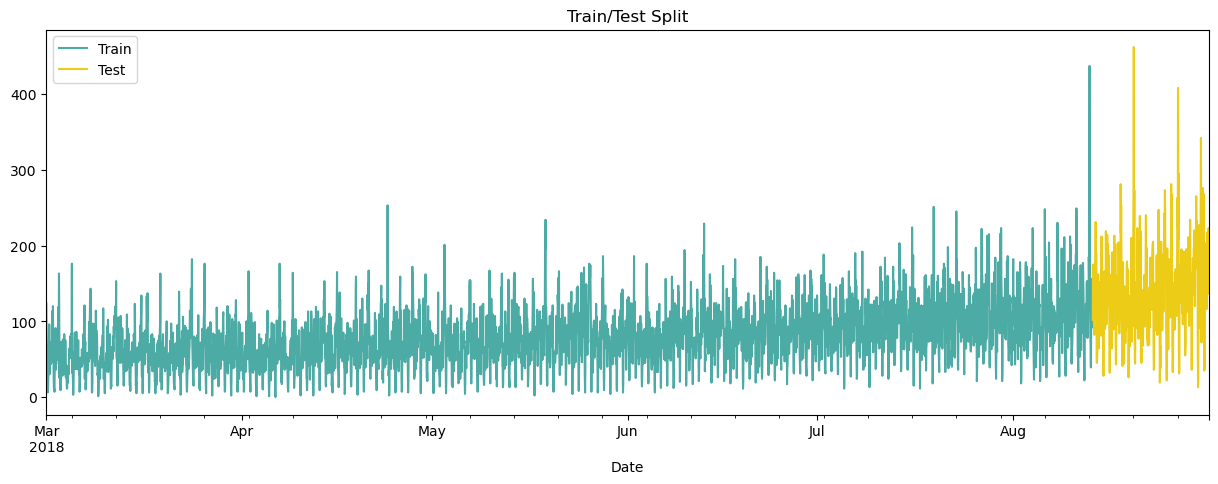

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))
train['num_orders'].plot(ax=ax, label='Train', title='Train/Test Split', color=my_colors[2])
test['num_orders'].plot(ax=ax, label='Test', color=my_colors[4])
ax.set_xlabel('Date')
ax.legend(['Train', 'Test'])
plt.show()

In [23]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

## <b><span style='color:#3778ba'>5 | </span><span style='color:#3778ba'>Модели</span></b>

### <b><span style='color:#4caba4'>Baseline</span></b>

In [24]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print('RMSE', mean_squared_error(y_test, pred_previous, squared=False))


RMSE 58.856486242815066


### <b><span style='color:#4caba4'>Hyperparameter tunning</span></b>

**<span style="color:#4caba4; font-size:120%">XGBoost Regressor</span>** 

In [26]:
tss = TimeSeriesSplit(n_splits=5, gap=24)

In [27]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.1],
           'n_estimators': [100, 500, 700],
           'colsample_bytree': [0.3, 0.7],}

In [28]:
%%time
xgbr = xgb.XGBRegressor()
clf = GridSearchCV(estimator=xgbr,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   cv=tss,
                   verbose=3,
                   n_jobs=-1)
clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 700}
Lowest RMSE:  25.017655206842154
CPU times: user 13.3 s, sys: 6.28 s, total: 19.5 s
Wall time: 42.8 s


**<span style="color:#4caba4; font-size:120%">LightGBM Regressor</span>** 

In [29]:
%%time
params = {'num_leaves': [10,20,40], 
          'num_iterations': [200, 1000, 1500],
          'max_depth': [5, 10,20],
          'learning_rate':[0.01,0.1], 
          'bagging_fraction':[0.5,0.8]}
lgbr = lgb.LGBMRegressor(objective='root_mean_squared_error')
lgbr_clf = GridSearchCV(estimator=lgbr,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=3,
                   n_jobs=-1,
                   cv=tss)
lgbr_clf.fit(X_train, y_train)

print("Best parameters:", lgbr_clf.best_params_)
print("Lowest RMSE: ", (-lgbr_clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/u

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
Best parameters: {'bagging_fraction': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_iterations': 1500, 'num_leaves': 10}
Lowest RMSE:  24.696887572008954
CPU times: user 3.13 s, sys: 1.87 s, total: 5.01 s
Wall time: 43.1 s


<div style="padding:10px; color:white; font-size:120%; display:fill; background-color:#4caba4;">
    
Best model - LGBMRegressor with parameter {'bagging_fraction': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_iterations': 1500, 'num_leaves': 10} shows RMSE=24.7
    
</div>

### **<span style="color:#4caba4">Cross-validation of best model</span>** 

In [30]:
lgbr_best = lgbr_clf.best_estimator_

In [31]:
cv_results = cross_validate(lgbr_best, X_train, y_train, cv=tss, scoring='neg_root_mean_squared_error')

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


In [32]:
print('RMSE', - cv_results['test_score'].mean())

RMSE 24.423111623729376


<div style="padding:10px; color:white; font-size:120%; display:fill; background-color:#4caba4;">
    
The indicator of the selected LGBMRegressor model on cross-validation is better than BaseLine
    
</div>

### <b><span style='color:#4caba4'>Model testing</span></b>

In [33]:
test['pred_num_orders'] = lgbr_best.predict(X_test)

In [34]:
mean_squared_error(y_test, test['pred_num_orders'], squared=False)

40.187825507102914

In [35]:
orders_all = pd.concat([test, train], sort=False)

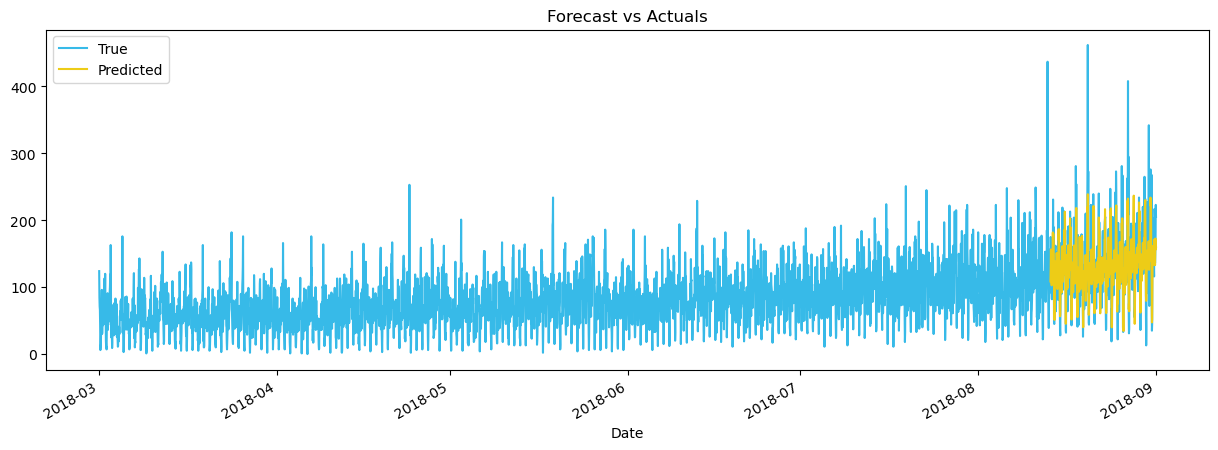

In [36]:
f, ax = plt.subplots(1, figsize=(15, 5))
orders_all[['num_orders','pred_num_orders']].plot(ax=ax,
                                                 style=['-'],
                                                 color=[my_colors[1], my_colors[4]])
ax.set_xlabel('Date')
ax.legend(['True', 'Predicted'])
ax.set_title('Forecast vs Actuals')

plt.show()

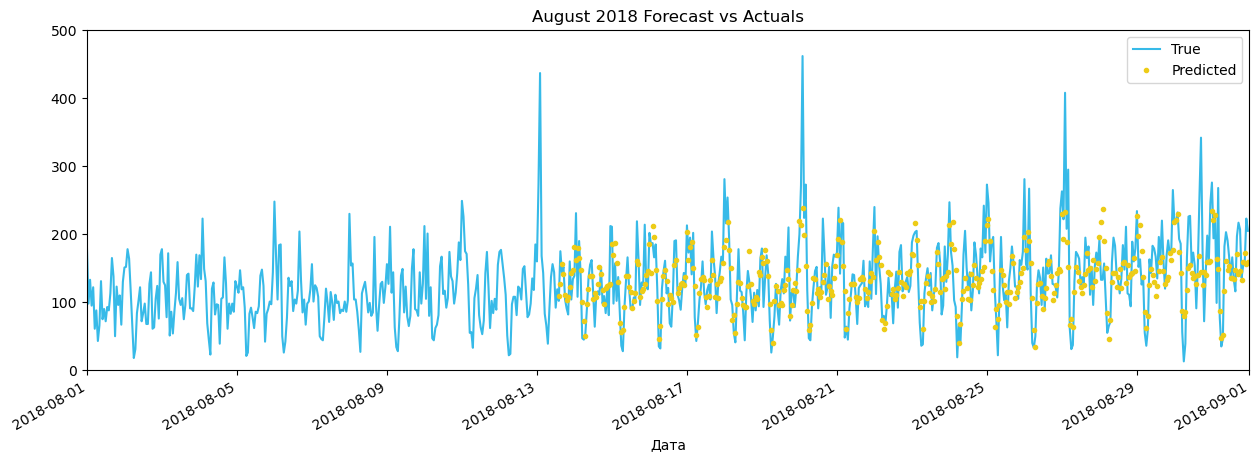

In [37]:
f, ax = plt.subplots(1, figsize=(15, 5))
orders_all[['num_orders','pred_num_orders']].plot(ax=ax,
                                                 style=['-','.'],
                                                 color=[my_colors[1], my_colors[4]])
ax.set_xbound(lower='08-2018', upper='09-2018')
ax.set_ylim(0, 500)
ax.set_xlabel('Дата')
ax.legend(['True', 'Predicted'])
ax.set_title('August 2018 Forecast vs Actuals')

plt.show()

<div style="padding:10px; color:white; font-size:120%; display:fill; background-color:#4caba4;">
    
The model copes well with predictions close to the mean, but fails at high values.
</div>

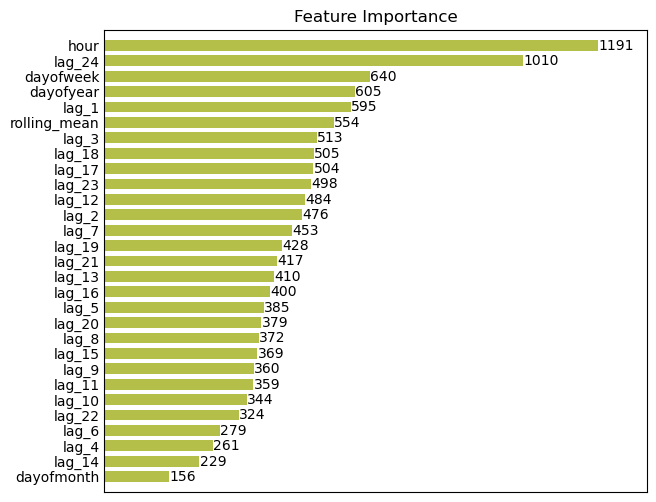

In [38]:
f, ax = plt.subplots(1, figsize=(7, 6))
lgb.plot_importance(lgbr_best, ax=ax, height=0.7, color=my_colors[3], grid=False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(length=0)
ax.set_xticklabels('')
ax.set_title('Feature Importance')
plt.show()

<div style="padding:10px; color:white; font-size:120%; display:fill; background-color:#4caba4;">
The most important features are the hour and day of the year.
    
</div>

## <b><span style='color:#3778ba'>6 |</span><span style='color:#3778ba'> Conclusions </span></b>

1. A brief analysis was carried out and features were added for training the model
2. Hyperparameters were selected for two models XGBoostRegressor and LightGBMRegressor
3. The best quality on cross-validation was shown by the LGBMRegressor model with parameters {'bagging_fraction': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_iterations': 1500, 'num_leaves': 10} showed RMSE=24.7
4. On the test sample, we got RMSE=40.2
5. Seasonality is observed: at night there are fewer orders with a minimum around 6 am, and in the evening demand is growing with a maximum around midnight.

+ It would be interesting to add features for weekends and holidays, or add a weather data source.